# 1.資料處理

In [2]:
import pandas as pd
data = pd.read_csv('1734final.csv')
data['ROI%'] = data['ROI%'].shift(-1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


columns = [
    'Price Open', 'Price High', 'Price Low', 'Price Close', 'Volume(1000shares)', 'turnover(1000)',
    'sma5', 'sma10', 'sma20', 'k', 'd', 'bias5', 'bias10', 'bias20', 'rsi', 'w%r', 'mtm', 'macd', 'macd_signal',
    'macdhist', 'ar', 'br', 'dmi', 'MV%','Market Capital', 'P/E', 'P/B', 'Long PSTN VAL', 'Short PSTN VAL',
    'Qfii Net S/B M.Cap', 'Fund Net S/B M.Cap', 'Dealer Net S/B M.Cap', 'Quarter', 'Liabilities Ratio',
    'ROA-Comprehensive Income', 'ROE-Comprehensive Income', 'Net Income Ratio', 'Return on Total Assets Growth Rate - YOY',
    'Recurring EPS', 'P/E Ratio at Quarter-End', 'Cash Dividend Yield', 'Dividend Yield', 'Current Ratio',
    'Acid-Test Ratio', 'Equity Turnover', 'Inventory Turnover'
]

encoded_data = {col: le.fit_transform(data[col]) for col in columns}
X = pd.DataFrame(encoded_data)
X.drop(X.index[-1], axis=0, inplace=True)
predict=[]
for i in data['ROI%']:
    if i>0:
        predict.append(1)
    else:
        False
        predict.append(0)

data['RR']=predict
y=data['RR']
y.drop(index=y.index[-1],axis=0,inplace=True)
counts = y.value_counts()

# 計算百分比
percentages = y.value_counts(normalize=True) * 100

# 輸出結果
print("各類別個數:")
print(counts)
print("\n各類別百分比:")
print(percentages)

各類別個數:
RR
0    1973
1    1504
Name: count, dtype: int64

各類別百分比:
RR
0    56.74432
1    43.25568
Name: proportion, dtype: float64


# 2.類神經網路


  Using cached tensorflow-2.13.1-cp38-cp38-win_amd64.whl (1.9 kB)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 322       
                                                                 
 dense_1 (Dense)             (None, 7)                 56        
                                                                 
 dense_2 (Dense)             (None, 1)                 8         
                                                                 
Total params: 386 (1.51 KB)
Trainable params: 386 (1.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/150
2/2 [==============================] - 1s 8ms/step - loss: 0.6931 - acc: 0.5204 - mse: 0.2500 - getRecall: 0.3766 - getPrecision: 0.4830
Epoch 2/150
2/2 [==============================] - 0s 6ms/step - loss:

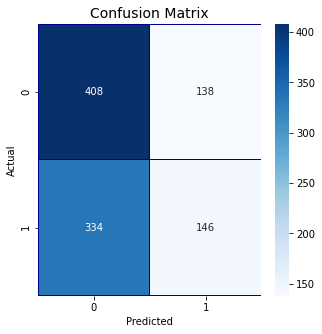

33/33 [==============================] - 0s 672us/step


0.5305173992673993

In [6]:
#個別模型準確率:Artificial neural network
!pip install --upgrade tensorflow
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


np.random.seed(0)
tf.random.set_seed(100)
#讀取資料和資料處理
#讀取資料
bank=pd.read_csv("1734final.csv")
bank = bank.drop(['Instrument','Date'],axis=1)
bank['ROI%'] = bank['ROI%'].shift(-1)

# 提取特徵欄位名稱
feature_names = bank.drop(['ROI%'], axis=1).columns.tolist()

X = bank.drop(['ROI%'],axis=1)
X=pd.DataFrame(X)
X.drop(index=X.index[-1],axis=0,inplace=True)

#資料標準化
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X=sc.fit_transform(X)
X=pd.DataFrame(X,columns=feature_names)
static=X.describe()
#X.info()
#a=pd.DataFrame(X.corr())



predict=[]
for i in bank['ROI%']:
    if i>0:
        predict.append(1)
    else:
        False
        predict.append(0)

bank['ROI%']=predict
y=bank['ROI%']
y.drop(index=y.index[-1],axis=0,inplace=True)




#資料切割
#資料切割(2020/1/2前為疫情前，後為疫情後)
split_index=2452
X_train=X.iloc[:split_index]
X_test=X.iloc[split_index:]
y_train=y.iloc[:split_index]
y_test=y.iloc[split_index:]



classifier=Sequential()

classifier.add(Dense(units=7,kernel_initializer='uniform',activation='relu',input_dim=45))
classifier.add(Dense(units=7,kernel_initializer='uniform',activation='relu'))
classifier.add(Dense(units=1,kernel_initializer='uniform',activation='sigmoid'))

import keras.backend as K
def getRecall(y_true,y_pred):
    true_positives=K.sum(K.round(K.clip(y_true*y_pred,0,1)))
    possible_positives=K.sum(K.round(K.clip(y_true,0,1)))
    recall=true_positives/(possible_positives+K.epsilon())
    return recall

def getPrecision(y_true,y_pred):
    true_positives=K.sum(K.round(K.clip(y_true*y_pred,0,1)))
    predicted_positives=K.sum(K.round(K.clip(y_pred,0,1)))
    precision=true_positives/(predicted_positives+K.epsilon())
    return precision

classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc','mse',getRecall,getPrecision])
print(classifier.summary())

import time
start_time = time.time()
classifier.fit(X_train,y_train,batch_size=1500,epochs=150)
end_time = time.time()
elapsed_time = end_time - start_time
print('類神經網路運算時間:', elapsed_time, '秒')

scores_train=classifier.evaluate(X_train,y_train)
scores_test=classifier.evaluate(X_test,y_test)
print('訓練集準確率:',scores_train[1])
print('測試集準確率:',scores_test[1])



y_pred_proba = classifier.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)
y_pred = np.reshape(y_pred, (-1))



from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

cm=pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted'])
fig,(ax1)=plt.subplots(ncols=1,figsize=(5,5))
sns.heatmap(cm,
           xticklabels=['0','1'],
           yticklabels=['0','1'],
           annot=True, fmt='g',ax=ax1,
           linewidths=.2,linecolor='Darkblue',cmap='Blues'
           )
print('混淆矩陣:\n',confusion_matrix(y_test, y_pred))
plt.title('Confusion Matrix',fontsize=14)
plt.show()

from sklearn.metrics import confusion_matrix,roc_curve,auc

y_pred_proba=classifier.predict(X_test)
[fpr,tpr,thr]=roc_curve(y_test,y_pred_proba)
idx=np.min(np.where(tpr>0.95))

idx2=np.min(np.where(tpr>0.90))

auc(fpr,tpr)

# 3.決策樹

Best params: {'model__min_samples_leaf': 65, 'model__min_samples_split': 10, 'selector__k': 21}
Selected Features: Index(['k', 'bias5', 'bias10', 'bias20', 'rsi', 'w%r', 'mtm', 'macd',
       'macdhist', 'br', 'Qfii Net S/B M.Cap', 'Fund Net S/B M.Cap',
       'ROA-Comprehensive Income', 'ROE-Comprehensive Income',
       'Net Income Ratio', 'Return on Total Assets Growth Rate - YOY',
       'Recurring EPS', 'Cash Dividend Yield', 'Dividend Yield',
       'Acid-Test Ratio', 'Equity Turnover'],
      dtype='object')
程式執行時間： 0.03517794609069824 秒
Accuracy: 50.49%
混淆矩陣:
 [[364 182]
 [326 154]]
AUC: 0.5144440628815629
              precision    recall  f1-score   support

           0       0.53      0.67      0.59       546
           1       0.46      0.32      0.38       480

    accuracy                           0.50      1026
   macro avg       0.49      0.49      0.48      1026
weighted avg       0.50      0.50      0.49      1026

                   pre       rec       spe        f

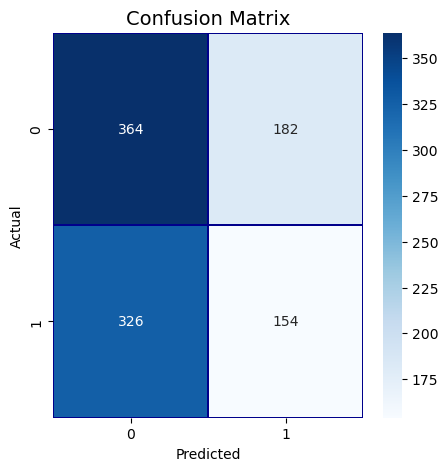

In [2]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd


#讀取資料
bank=pd.read_csv("1734final.csv")
bank = bank.drop(['Instrument','Date'],axis=1)
bank['ROI%'] = bank['ROI%'].shift(-1)

# 提取特徵欄位名稱
feature_names = bank.drop(['ROI%'], axis=1).columns.tolist()

X = bank.drop(['ROI%'],axis=1)
X=pd.DataFrame(X)
X.drop(index=X.index[-1],axis=0,inplace=True)

#資料標準化
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X=sc.fit_transform(X)
X=pd.DataFrame(X,columns=feature_names)
static=X.describe()
#X.info()
#a=pd.DataFrame(X.corr())



predict=[]
for i in bank['ROI%']:
    if i>0:
        predict.append(1)
    else:
        False
        predict.append(0)

bank['ROI%']=predict
y=bank['ROI%']
y.drop(index=y.index[-1],axis=0,inplace=True)

#資料切割(2020/1/2前為疫情前，後為疫情後)
split_index=2452
X_train=X.iloc[:split_index]
X_test=X.iloc[split_index:]
y_train=y.iloc[:split_index]
y_test=y.iloc[split_index:]

#特徵選取
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np
pipeline = Pipeline([('selector',SelectKBest(f_regression)),('model',DecisionTreeClassifier(random_state = 100))])

search = GridSearchCV(
    estimator = pipeline,
    param_grid = {'selector__k':[15,16,17,18,19,20,21],'model__min_samples_leaf':np.arange(10,100,5),'model__min_samples_split':np.arange(10,100,5)},
    n_jobs=-1,
    scoring="accuracy",
    cv=5,
    verbose=0
)
search.fit(X,y)

# 獲取最佳特徵選擇器
best_selector = search.best_estimator_['selector']

# 獲取選擇的特徵索引
selected_features_indices = best_selector.get_support(indices=True)
selected_features = X.columns[selected_features_indices]
print('Best params:',search.best_params_)
print("Selected Features:", selected_features)


X_train_selected = X_train.iloc[:, selected_features_indices]
X_test_selected = X_test.iloc[:, selected_features_indices]

# 創建並訓練新的模型
model = DecisionTreeClassifier(random_state=100,
                               min_samples_leaf=search.best_params_['model__min_samples_leaf'],
                               min_samples_split=search.best_params_['model__min_samples_split'])

import time
start_time = time.time()
model.fit(X_train_selected, y_train)
#運算時間
end_time = time.time()
execution_time = end_time - start_time
print("程式執行時間：", execution_time, "秒")

# 在測試集上進行預測
y_pred = model.predict(X_test_selected)

# 評估模型
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", f'{accuracy*100:.2f}%')

#混淆矩陣畫圖
from sklearn.metrics import confusion_matrix,roc_curve,auc
import matplotlib.pyplot as plt
import seaborn as sns
y_pred=model.predict(X_test_selected)
cm=pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted'])
fig,(ax1)=plt.subplots(ncols=1,figsize=(5,5))
sns.heatmap(cm,
           xticklabels=['0','1'],
           yticklabels=['0','1'],
           annot=True, fmt='g',ax=ax1,
           linewidths=.2,linecolor='Darkblue',cmap='Blues'
           )
print('混淆矩陣:\n',confusion_matrix(y_test, y_pred))
plt.title('Confusion Matrix',fontsize=14)

#計算 AUC（曲線下面積）
y_pred_proba=model.predict_proba(X_test_selected)[:,1]
[fpr,tpr,thr]=roc_curve(y_test,y_pred_proba)
idx=np.min(np.where(tpr>0.95))

idx2=np.min(np.where(tpr>0.90))

print('AUC:',auc(fpr,tpr))

#效能衡量指標
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test,y_pred))




# 4.隨機森林

Best params: {'model__n_estimators': 10, 'selector__k': 17}
Selected Features: Index(['k', 'bias5', 'bias10', 'bias20', 'rsi', 'w%r', 'macdhist', 'br',
       'Fund Net S/B M.Cap', 'ROA-Comprehensive Income',
       'ROE-Comprehensive Income', 'Net Income Ratio',
       'Return on Total Assets Growth Rate - YOY', 'Recurring EPS',
       'Cash Dividend Yield', 'Dividend Yield', 'Equity Turnover'],
      dtype='object')
程式執行時間： 0.10065174102783203 秒
Accuracy: 51.85%
混淆矩陣:
 [[373 173]
 [321 159]]
AUC: 0.49768963675213673
              precision    recall  f1-score   support

           0       0.54      0.68      0.60       546
           1       0.48      0.33      0.39       480

    accuracy                           0.52      1026
   macro avg       0.51      0.51      0.50      1026
weighted avg       0.51      0.52      0.50      1026

                   pre       rec       spe        f1       geo       iba       sup

          0       0.54      0.68      0.33      0.60      0.48   

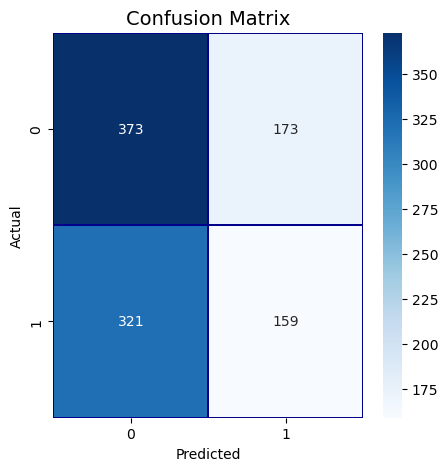

In [3]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

#讀取資料
bank=pd.read_csv("1734final.csv")
bank = bank.drop(['Instrument','Date'],axis=1)
bank['ROI%'] = bank['ROI%'].shift(-1)

# 提取特徵欄位名稱
feature_names = bank.drop(['ROI%'], axis=1).columns.tolist()

X = bank.drop(['ROI%'],axis=1)
X=pd.DataFrame(X)
X.drop(index=X.index[-1],axis=0,inplace=True)

#資料標準化
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X=sc.fit_transform(X)
X=pd.DataFrame(X,columns=feature_names)
static=X.describe()
#X.info()
#a=pd.DataFrame(X.corr())



predict=[]
for i in bank['ROI%']:
    if i>0:
        predict.append(1)
    else:
        False
        predict.append(0)

bank['ROI%']=predict
y=bank['ROI%']
y.drop(index=y.index[-1],axis=0,inplace=True)

#資料切割(2020/1/2前為疫情前，後為疫情後)
split_index=2452
X_train=X.iloc[:split_index]
X_test=X.iloc[split_index:]
y_train=y.iloc[:split_index]
y_test=y.iloc[split_index:]

#特徵選取
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np
pipeline = Pipeline([('selector',SelectKBest(f_regression)),('model',RandomForestClassifier(random_state = 100))])

search = GridSearchCV(
    estimator = pipeline,
    param_grid = {'selector__k':[15,16,17,18,19,20,21],'model__n_estimators':np.arange(10,200,10)},
    n_jobs=-1,
    scoring="accuracy",
    cv=5,
    verbose=0
)
search.fit(X,y)

# 獲取最佳特徵選擇器
best_selector = search.best_estimator_['selector']

# 獲取選擇的特徵索引
selected_features_indices = best_selector.get_support(indices=True)
selected_features = X.columns[selected_features_indices]
print('Best params:',search.best_params_)
print("Selected Features:", selected_features)


X_train_selected = X_train.iloc[:, selected_features_indices]
X_test_selected = X_test.iloc[:, selected_features_indices]

# 創建並訓練新的模型
model = RandomForestClassifier(random_state=100,
                               n_estimators=search.best_params_['model__n_estimators'],)

import time
start_time = time.time()
model.fit(X_train_selected, y_train)
#運算時間
end_time = time.time()
execution_time = end_time - start_time
print("程式執行時間：", execution_time, "秒")

# 在測試集上進行預測
y_pred = model.predict(X_test_selected)

# 評估模型
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", f'{accuracy*100:.2f}%')

#混淆矩陣畫圖
from sklearn.metrics import confusion_matrix,roc_curve,auc
import matplotlib.pyplot as plt
import seaborn as sns
y_pred=model.predict(X_test_selected)
cm=pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted'])
fig,(ax1)=plt.subplots(ncols=1,figsize=(5,5))
sns.heatmap(cm,
           xticklabels=['0','1'],
           yticklabels=['0','1'],
           annot=True, fmt='g',ax=ax1,
           linewidths=.2,linecolor='Darkblue',cmap='Blues'
           )
print('混淆矩陣:\n',confusion_matrix(y_test, y_pred))
plt.title('Confusion Matrix',fontsize=14)

#計算 AUC（曲線下面積）
y_pred_proba=model.predict_proba(X_test_selected)[:,1]
[fpr,tpr,thr]=roc_curve(y_test,y_pred_proba)
idx=np.min(np.where(tpr>0.95))

idx2=np.min(np.where(tpr>0.90))

print('AUC:',auc(fpr,tpr))


#效能衡量指標
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test,y_pred))




# 5.支援向量機SVM

Best params: {'model__C': 10, 'model__gamma': 0.001, 'selector__k': 20}
Selected Features: Index(['k', 'bias5', 'bias10', 'bias20', 'rsi', 'w%r', 'mtm', 'macd',
       'macdhist', 'br', 'Fund Net S/B M.Cap', 'ROA-Comprehensive Income',
       'ROE-Comprehensive Income', 'Net Income Ratio',
       'Return on Total Assets Growth Rate - YOY', 'Recurring EPS',
       'Cash Dividend Yield', 'Dividend Yield', 'Acid-Test Ratio',
       'Equity Turnover'],
      dtype='object')
程式執行時間： 1.6880991458892822 秒
Accuracy: 53.12%
混淆矩陣:
 [[544   2]
 [479   1]]
AUC: 0.5348557692307692
              precision    recall  f1-score   support

           0       0.53      1.00      0.69       546
           1       0.33      0.00      0.00       480

    accuracy                           0.53      1026
   macro avg       0.43      0.50      0.35      1026
weighted avg       0.44      0.53      0.37      1026

                   pre       rec       spe        f1       geo       iba       sup

          0   

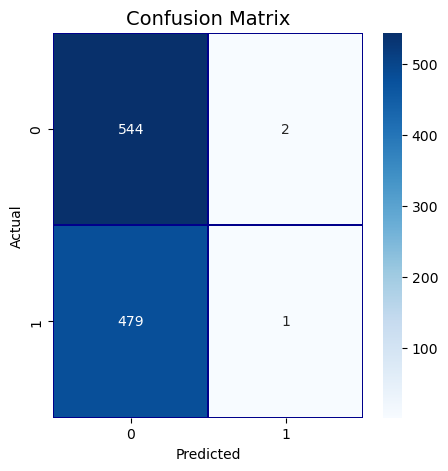

In [4]:
from sklearn import svm
from sklearn.svm import SVC
import pandas as pd

#讀取資料
bank=pd.read_csv("1734final.csv")
bank = bank.drop(['Instrument','Date'],axis=1)
bank['ROI%'] = bank['ROI%'].shift(-1)

# 提取特徵欄位名稱
feature_names = bank.drop(['ROI%'], axis=1).columns.tolist()

X = bank.drop(['ROI%'],axis=1)
X=pd.DataFrame(X)
X.drop(index=X.index[-1],axis=0,inplace=True)

#資料標準化
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X=sc.fit_transform(X)
X=pd.DataFrame(X,columns=feature_names)
static=X.describe()
#X.info()
#a=pd.DataFrame(X.corr())


predict=[]
for i in bank['ROI%']:
    if i>0:
        predict.append(1)
    else:
        False
        predict.append(0)

bank['ROI%']=predict
y=bank['ROI%']
y.drop(index=y.index[-1],axis=0,inplace=True)

#資料切割(2020/1/2前為疫情前，後為疫情後)
split_index=2452
X_train=X.iloc[:split_index]
X_test=X.iloc[split_index:]
y_train=y.iloc[:split_index]
y_test=y.iloc[split_index:]

#特徵選取
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np
pipeline = Pipeline([('selector',SelectKBest(f_regression)),('model',SVC(random_state = 100,probability=True))])

search = GridSearchCV(
    estimator = pipeline,
    param_grid = {'selector__k':[15,16,17,18,19,20,21],
                  'model__C':np.arange(10,50,10),
                  'model__gamma':[0.001,0.01,0.1]},
    n_jobs=-1,
    scoring="accuracy",
    cv=5,
    verbose=0
)
search.fit(X,y)

# 獲取最佳特徵選擇器
best_selector = search.best_estimator_['selector']

# 獲取選擇的特徵索引
selected_features_indices = best_selector.get_support(indices=True)
selected_features = X.columns[selected_features_indices]
print('Best params:',search.best_params_)
print("Selected Features:", selected_features)


X_train_selected = X_train.iloc[:, selected_features_indices]
X_test_selected = X_test.iloc[:, selected_features_indices]

# 創建並訓練新的模型
model = SVC(random_state=100,
            kernel='rbf',
            probability=True,
            gamma=search.best_params_['model__gamma'],
            C=search.best_params_['model__C'])

import time
start_time = time.time()
model.fit(X_train_selected, y_train)
#運算時間
end_time = time.time()
execution_time = end_time - start_time
print("程式執行時間：", execution_time, "秒")

# 在測試集上進行預測
y_pred = model.predict(X_test_selected)

# 評估模型
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", f'{accuracy*100:.2f}%')

#混淆矩陣畫圖
from sklearn.metrics import confusion_matrix,roc_curve,auc
import matplotlib.pyplot as plt
import seaborn as sns
y_pred=model.predict(X_test_selected)
cm=pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted'])
fig,(ax1)=plt.subplots(ncols=1,figsize=(5,5))
sns.heatmap(cm,
           xticklabels=['0','1'],
           yticklabels=['0','1'],
           annot=True, fmt='g',ax=ax1,
           linewidths=.2,linecolor='Darkblue',cmap='Blues'
           )
print('混淆矩陣:\n',confusion_matrix(y_test, y_pred))
plt.title('Confusion Matrix',fontsize=14)

#計算 AUC（曲線下面積）
y_pred_proba=model.predict_proba(X_test_selected)[:,1]
[fpr,tpr,thr]=roc_curve(y_test,y_pred_proba)
idx=np.min(np.where(tpr>0.95))

idx2=np.min(np.where(tpr>0.90))

print('AUC:',auc(fpr,tpr))


#效能衡量指標
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test,y_pred))




# 6.AdaBoost

Best params: {'model__learning_rate': 0.001, 'model__n_estimators': 50, 'selector__k': 15}
Selected Features: Index(['k', 'bias5', 'bias10', 'rsi', 'w%r', 'br', 'Fund Net S/B M.Cap',
       'ROA-Comprehensive Income', 'ROE-Comprehensive Income',
       'Net Income Ratio', 'Return on Total Assets Growth Rate - YOY',
       'Recurring EPS', 'Cash Dividend Yield', 'Dividend Yield',
       'Equity Turnover'],
      dtype='object')
AdaBoost運算時間: 0.5830070972442627 秒
Accuracy: 52.44%
              precision    recall  f1-score   support

           0     0.5395    0.7253    0.6188       546
           1     0.4863    0.2958    0.3679       480

    accuracy                         0.5244      1026
   macro avg     0.5129    0.5106    0.4933      1026
weighted avg     0.5146    0.5244    0.5014      1026

                   pre       rec       spe        f1       geo       iba       sup

          0       0.54      0.73      0.30      0.62      0.46      0.22       546
          1       0.49 

0.5105540293040293

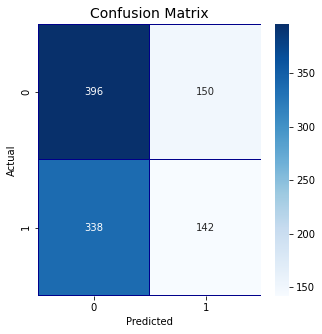

In [4]:
import pandas as pd
!pip install imbalanced-learn
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

#讀取資料
bank=pd.read_csv("1734final.csv")
bank = bank.drop(['Instrument','Date'],axis=1)
bank['ROI%'] = bank['ROI%'].shift(-1)

# 提取特徵欄位名稱
feature_names = bank.drop(['ROI%'], axis=1).columns.tolist()

X = bank.drop(['ROI%'],axis=1)
X=pd.DataFrame(X)
X.drop(index=X.index[-1],axis=0,inplace=True)

#資料標準化
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X=sc.fit_transform(X)
X=pd.DataFrame(X,columns=feature_names)
static=X.describe()
#X.info()
#a=pd.DataFrame(X.corr())



predict=[]
for i in bank['ROI%']:
    if i>0:
        predict.append(1)
    else:
        False
        predict.append(0)

bank['ROI%']=predict
y=bank['ROI%']
y.drop(index=y.index[-1],axis=0,inplace=True)

#資料切割(2020/1/2前為疫情前，後為疫情後)
split_index=2452
X_train=X.iloc[:split_index]
X_test=X.iloc[split_index:]
y_train=y.iloc[:split_index]
y_test=y.iloc[split_index:]

#特徵選取
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np
pipeline = Pipeline([('selector',SelectKBest(f_regression)),('model',AdaBoostClassifier(random_state = 100))])

param_grid = {
    'selector__k': [15, 16, 17, 18, 19, 20, 21],
    'model__n_estimators':range(50, 250,50),
    'model__learning_rate':[0.001,0.01,0.1]

}
search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    scoring="accuracy",
    cv=5,
    verbose=0
)
search.fit(X,y)

# 獲取最佳特徵選擇器
best_selector = search.best_estimator_['selector']

# 獲取選擇的特徵索引
selected_features_indices = best_selector.get_support(indices=True)
selected_features = X.columns[selected_features_indices]
print('Best params:',search.best_params_)
print("Selected Features:", selected_features)


X_train_selected = X_train.iloc[:, selected_features_indices]
X_test_selected = X_test.iloc[:, selected_features_indices]

# 創建並訓練新的模型
model = AdaBoostClassifier(random_state=100,
                      n_estimators=search.best_params_[ 'model__n_estimators'],
                      learning_rate=search.best_params_['model__learning_rate']
                     )
#計算時間
import time
start_time = time.time()
model.fit(X_train_selected, y_train)
end_time = time.time()
elapsed_time = end_time - start_time

print('AdaBoost運算時間:', elapsed_time, '秒')


# 在測試集上進行預測
y_pred = model.predict(X_test_selected)

# 評估模型
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", f'{accuracy*100:.2f}%')


#效能衡量指標
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))

from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test,y_pred))

#混淆矩陣
from sklearn.metrics import confusion_matrix,roc_curve,auc
y_pred=model.predict(X_test_selected)
cm=pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted'])
fig,(ax1)=plt.subplots(ncols=1,figsize=(5,5))
sns.heatmap(cm,
           xticklabels=['0','1'],
           yticklabels=['0','1'],
           annot=True, fmt='g',ax=ax1,
           linewidths=.2,linecolor='Darkblue',cmap='Blues'
           )
print('混淆矩陣:\n',confusion_matrix(y_test, y_pred))
plt.title('Confusion Matrix',fontsize=14)

#計算 AUC（曲線下面積）
y_pred_proba=model.predict_proba(X_test_selected)[:,1]
[fpr,tpr,thr]=roc_curve(y_test,y_pred_proba)
idx=np.min(np.where(tpr>0.95))

idx2=np.min(np.where(tpr>0.90))

auc(fpr,tpr)


# 7.XGBoost

Best params: {'model__learning_rate': 0.01, 'model__max_depth': 4, 'model__min_child_weight': 15, 'model__n_estimators': 30, 'selector__k': 18}
Selected Features: Index(['k', 'bias5', 'bias10', 'bias20', 'rsi', 'w%r', 'macd', 'macdhist',
       'br', 'Fund Net S/B M.Cap', 'ROA-Comprehensive Income',
       'ROE-Comprehensive Income', 'Net Income Ratio',
       'Return on Total Assets Growth Rate - YOY', 'Recurring EPS',
       'Cash Dividend Yield', 'Dividend Yield', 'Equity Turnover'],
      dtype='object')
XG Boost運算時間: 0.035230398178100586 秒
Accuracy: 53.22%
              precision    recall  f1-score   support

           0     0.5322    1.0000    0.6947       546
           1     0.0000    0.0000    0.0000       480

    accuracy                         0.5322      1026
   macro avg     0.2661    0.5000    0.3473      1026
weighted avg     0.2832    0.5322    0.3697      1026

                   pre       rec       spe        f1       geo       iba       sup

          0       0.5

0.4872519841269841

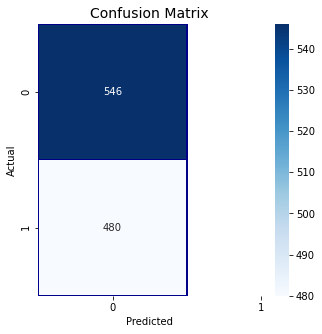

In [8]:
import pandas as pd
!pip install imbalanced-learn
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

#讀取資料
bank=pd.read_csv("1734final.csv")
bank = bank.drop(['Instrument','Date'],axis=1)
bank['ROI%'] = bank['ROI%'].shift(-1)

# 提取特徵欄位名稱
feature_names = bank.drop(['ROI%'], axis=1).columns.tolist()

X = bank.drop(['ROI%'],axis=1)
X=pd.DataFrame(X)
X.drop(index=X.index[-1],axis=0,inplace=True)

#資料標準化
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X=sc.fit_transform(X)
X=pd.DataFrame(X,columns=feature_names)
static=X.describe()
#X.info()
#a=pd.DataFrame(X.corr())



predict=[]
for i in bank['ROI%']:
    if i>0:
        predict.append(1)
    else:
        False
        predict.append(0)

bank['ROI%']=predict
y=bank['ROI%']
y.drop(index=y.index[-1],axis=0,inplace=True)

#資料切割(2020/1/2前為疫情前，後為疫情後)
split_index=2452
X_train=X.iloc[:split_index]
X_test=X.iloc[split_index:]
y_train=y.iloc[:split_index]
y_test=y.iloc[split_index:]

#特徵選取
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np
pipeline = Pipeline([('selector',SelectKBest(f_regression)),('model',XGBClassifier(random_state = 100))])

param_grid = {
    'selector__k': [15, 16, 17, 18, 19, 20, 21],
    'model__max_depth': range(2,10,2),
    'model__min_child_weight':range(5,21,5),
    'model__n_estimators':range(10, 200, 20),
    'model__learning_rate':[0.001,0.01,0.1]

}
search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    scoring="accuracy",
    cv=5,
    verbose=0
)
search.fit(X,y)

# 獲取最佳特徵選擇器
best_selector = search.best_estimator_['selector']

# 獲取選擇的特徵索引
selected_features_indices = best_selector.get_support(indices=True)
selected_features = X.columns[selected_features_indices]
print('Best params:',search.best_params_)
print("Selected Features:", selected_features)


X_train_selected = X_train.iloc[:, selected_features_indices]
X_test_selected = X_test.iloc[:, selected_features_indices]

# 創建並訓練新的模型
model = XGBClassifier(random_state=100,
                      max_depth=search.best_params_['model__max_depth'],
                      min_child_weight=search.best_params_['model__min_child_weight'],
                      n_estimators=search.best_params_[ 'model__n_estimators'],
                      learning_rate=search.best_params_['model__learning_rate']
                     )
#計算時間
import time
start_time = time.time()
model.fit(X_train_selected, y_train)
end_time = time.time()
elapsed_time = end_time - start_time

print('XG Boost運算時間:', elapsed_time, '秒')


# 在測試集上進行預測
y_pred = model.predict(X_test_selected)

# 評估模型
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", f'{accuracy*100:.2f}%')


#效能衡量指標
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,zero_division=0,digits=4))

from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test,y_pred,zero_division=0))

#混淆矩陣
from sklearn.metrics import confusion_matrix,roc_curve,auc
y_pred=model.predict(X_test_selected)
cm=pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted'])
fig,(ax1)=plt.subplots(ncols=1,figsize=(5,5))
sns.heatmap(cm,
           xticklabels=['0','1'],
           yticklabels=['0','1'],
           annot=True, fmt='g',ax=ax1,
           linewidths=.2,linecolor='Darkblue',cmap='Blues'
           )
print('混淆矩陣:\n',confusion_matrix(y_test, y_pred))
plt.title('Confusion Matrix',fontsize=14)

#計算 AUC（曲線下面積）
y_pred_proba=model.predict_proba(X_test_selected)[:,1]
[fpr,tpr,thr]=roc_curve(y_test,y_pred_proba)
idx=np.min(np.where(tpr>0.95))

idx2=np.min(np.where(tpr>0.90))

auc(fpr,tpr)

# 8.Stacking全學習器

In [5]:
from vecstack import stacking
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

#讀取資料
bank=pd.read_csv("1734final.csv")
bank = bank.drop(['Instrument','Date'],axis=1)
bank['ROI%'] = bank['ROI%'].shift(-1)

# 提取特徵欄位名稱
feature_names = bank.drop(['ROI%'], axis=1).columns.tolist()

X = bank.drop(['ROI%'],axis=1)
X=pd.DataFrame(X)
X.drop(index=X.index[-1],axis=0,inplace=True)

#資料標準化
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X=sc.fit_transform(X)
X=pd.DataFrame(X,columns=feature_names)
static=X.describe()
#X.info()
#a=pd.DataFrame(X.corr())


predict=[]
for i in bank['ROI%']:
    if i>0:
        predict.append(1)
    else:
        False
        predict.append(0)

bank['ROI%']=predict
y=bank['ROI%']
y.drop(index=y.index[-1],axis=0,inplace=True)

#資料切割(2020/1/2前為疫情前，後為疫情後)
split_index=2452
X_train=X.iloc[:split_index]
X_test=X.iloc[split_index:]
y_train=y.iloc[:split_index]
y_test=y.iloc[split_index:]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
import keras.backend as K
def getRecall(y_true,y_pred):
    true_positives = tf.cast(K.sum(K.round(K.clip(y_true*y_pred, 0, 1))), tf.float32)
    possible_positives = tf.cast(K.sum(K.round(K.clip(y_true, 0, 1))), tf.float32)
    recall=true_positives/(possible_positives+K.epsilon())
    return recall

def getPrecision(y_true,y_pred):
    true_positives = tf.cast(K.sum(K.round(K.clip(y_true*y_pred, 0, 1))), tf.float32)
    predicted_positives = tf.cast(K.sum(K.round(K.clip(y_true, 0, 1))), tf.float32)

    precision=true_positives/(predicted_positives+K.epsilon())
    return precision



def create_model_s():
    model=Sequential()
    model.add(Dense(units=7,kernel_initializer='uniform',activation='relu',input_dim=45))
    model.add(Dense(units=7,kernel_initializer='uniform',activation='relu'))
    model.add(Dense(units=1,kernel_initializer='uniform',activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc','mse',getRecall,getPrecision])
    return model





#Stacking
models = [
    DecisionTreeClassifier(random_state=100, min_samples_leaf=65,min_samples_split=10),

    RandomForestClassifier(random_state=100, n_estimators=10),

    XGBClassifier(random_state=100, learning_rate=0.01,max_depth=4,min_child_weight=15,n_estimators=30),

    SVC(random_state=100,kernel='rbf',gamma=0.001,C=10,probability=False),

    AdaBoostClassifier(random_state=100,n_estimators=50,learning_rate=0.001),

    KerasClassifier(build_fn=create_model_s,epochs=150,batch_size=1200)
]


# 堆叠
import time
start_time = time.time()


S_train, S_test = stacking(models,
                           X_train, y_train, X_test,
                           regression=False,
                           needs_proba=False,
                           save_dir=None,
                           metric=accuracy_score,
                           n_folds=5,
                           stratified=True,
                           shuffle=True,
                           random_state=100,
                           verbose=2)
end_time = time.time()
elapsed_time = end_time - start_time

print('集成模型運算時間:', elapsed_time, '秒')
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
# 使用Logistic來評估特徵的重要性
model_svm=linear_model.LogisticRegression(C=10,penalty='l2',solver='liblinear',random_state=100)
model_svm=model_svm.fit(S_train,y_train)

test_prob=model_svm.predict(S_test)
test_prob.shape

#計算模型準確率
accuracy_train = model_svm.score(S_train, y_train)
accuracy_test = model_svm.score(S_test, y_test)
print('訓練集準確率:', accuracy_train)
print('測試集準確率:', accuracy_test)

from sklearn.metrics import confusion_matrix

# 混淆矩陣
y_pred = model_svm.predict(S_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
fig, ax1 = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
           xticklabels=['0','1'],
           yticklabels=['0','1'],
           annot=True, fmt='g', ax=ax1,
           linewidths=.2, linecolor='Darkblue', cmap='Blues'
           )
print('集成模型混淆矩陣:\n', confusion_matrix(y_test, y_pred))
plt.title('Confusion Matrix', fontsize=14)
plt.show()

#混淆矩陣指標
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc
y_pred=model_svm.predict(S_test)
print(classification_report(y_test, y_pred, zero_division=0))

y_pred=model_svm.predict(S_test)
y_pred_proba=model_svm.predict_proba(S_test)[:,1]
[fpr,tpr,thr]=roc_curve(y_test,y_pred_proba)
idx=np.min(np.where(tpr>0.95))

idx2=np.min(np.where(tpr>0.90))

auc(fpr,tpr)
print('AUC:',auc(fpr,tpr))

# 顯示Logistic Regression模型的係數
print("Logistic Regression coefficients:")
coefficients = model_svm.coef_[0]
print(coefficients)

# 顯示截距
print("Logistic Regression intercept:")
print(model_svm.intercept_)



ModuleNotFoundError: No module named 'scikeras'